# 测试自相关

In [1]:
!pip install array_to_latex

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [3]:
fs = 10e3
N = 1e5
freq = 1000.0
time = np.arange(N) / fs
amp = 2*np.sqrt(2)
noise_power = 0.001 * fs / 2
x = amp*np.sin(2*np.pi*freq*time)
x += rng.normal(scale=np.sqrt(noise_power), size=time.shape)

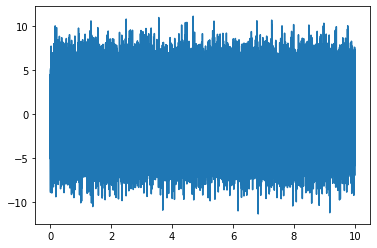

In [4]:
plt.plot(time,x)

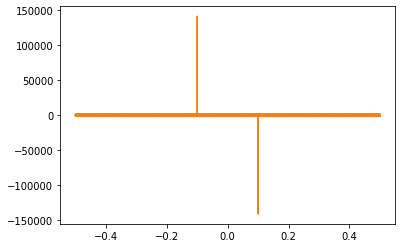

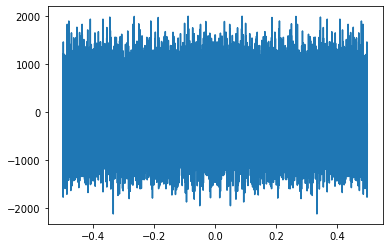

In [5]:
fft_amp = np.fft.fft(x)
freq = np.fft.fftfreq(x.shape[-1])
plt.plot(freq, fft_amp.real, freq, fft_amp.imag)
plt.show()
plt.plot(freq, fft_amp.real)
plt.show()

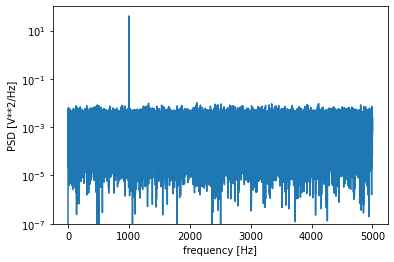

In [6]:
f, Pxx_den = signal.periodogram(x, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

(513,)


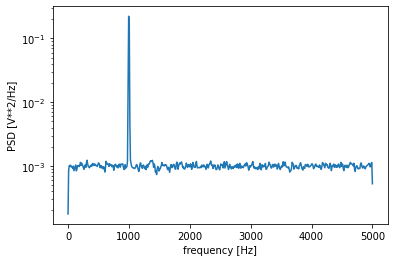

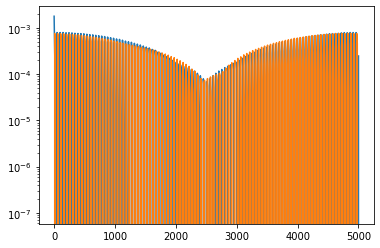

In [7]:
# ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch
f, pxx_full = signal.welch(x, fs, nperseg=1024)
print(f.shape)
plt.semilogy(f, pxx_full)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
r_amp_r = np.fft.ifft(pxx_full).real
r_amp_i = np.fft.ifft(pxx_full).imag
plt.semilogy(f, r_amp_r, f, r_amp_i)
plt.show()

# 生成自相关矩阵

## 方案
用 toeplitz 矩阵生成自相关, toeplitz矩阵的生成方法
```python
from scipy.linalg import toeplitz
toeplitz(np.pad(x, (0,len(x)-1),mode='constant'),np.pad([x[0]], (0,len(x)-1),mode='constant'))
```
参考[scipy toeplitz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html)

python的做法如下
```python
import numpy as np
from scipy.linalg import toeplitz
x = np.asarray([1,2,3,4])
toeplitz(np.pad(x, (0,len(x)-1),mode='constant'),np.pad([x[0]], (0,len(x)-1),mode='constant'))@x[::-1]
# output: array([ 4, 11, 20, 30, 20, 11, 4])
```

In [8]:
from scipy.linalg import toeplitz

def getRxx(x):
    acf = np.convolve(x,np.conj(x)[::-1]) # compute Auto-correlation sequence
    Rxx=acf[2:]; # R_xx(0) is the center element
    Rx = toeplitz(Rxx,np.hstack((Rxx[0], np.conj(Rxx[1:]))))
    return Rx

Rx = getRxx(x[:256])
print(Rx.shape)
print(Rx[:5,:5])

(509, 509)
[[ 6.49193303 17.3276383  11.75797432 21.55579619  9.71962448]
 [17.3276383   6.49193303 17.3276383  11.75797432 21.55579619]
 [11.75797432 17.3276383   6.49193303 17.3276383  11.75797432]
 [21.55579619 11.75797432 17.3276383   6.49193303 17.3276383 ]
 [ 9.71962448 21.55579619 11.75797432 17.3276383   6.49193303]]


# LD 算法实现

## 信号生成
参考 [scipy lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter)

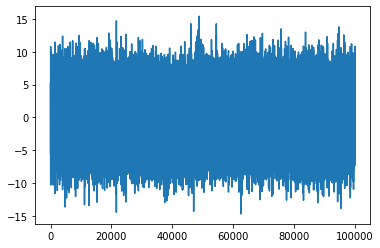

In [9]:
N = 1e5
time = np.arange(N)
a0 = np.array([1, 0.86, 0.67])
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
x = signal.lfilter(np.array([1]), a0, noise)

plt.plot(time, x)
plt.savefig("output/AR_signal.pdf")

In [10]:
def correlation(x, maxlags=None, norm='unbiased'):
    assert norm in ['unbiased','biased', None]
    #transform lag into list if it is an integer
    x = np.array(x)
    y = x
    # N is the max of x and y
    N = len(x)

    #default lag is N-1
    if maxlags is None:
        maxlags = N - 1
    assert maxlags < N, 'lag must be less than len(x)'

    realdata = np.isrealobj(x) and np.isrealobj(y)
    #create an autocorrelation array with same length as lag
    if realdata == True:
        r = np.zeros(maxlags, dtype=float)
    else:
        r = np.zeros(maxlags, dtype=complex)

    for k in range(0, maxlags+1):
        nk = N - k - 1

        if realdata == True:
            sum = 0
            for j in range(0, nk+1):
                sum = sum + x[j+k] * y[j]
        else:
            sum = 0. + 0j
            for j in range(0, nk+1):
                sum = sum + x[j+k] * y[j].conjugate()
        if k == 0:
            if norm in ['biased', 'unbiased']:
                r0 = sum/float(N)
            elif norm is None:
                r0 = sum
            else:
                r0 =  1.
        else:
            if norm == 'unbiased':
                r[k-1] = sum / float(N-k)
            elif norm == 'biased':
                r[k-1] = sum / float(N)
            elif norm is None:
                r[k-1] = sum

    r = np.insert(r, 0, r0)
    return r

def LenvinsoDurbin(r, order=None, allow_singularity=False):
    #from numpy import isrealobj
    T0  = np.real(r[0])
    T = r[1:]
    M = len(T)

    if order is None:
        M = len(T)
    else:
        assert order <= M, 'order must be less than size of the input data'
        M = order

    realdata = np.isrealobj(r)
    if realdata is True:
        A = np.zeros(M, dtype=float)
        ref = np.zeros(M, dtype=float)
        AH = np.zeros([M, M], dtype=float)
    else:
        A = np.zeros(M, dtype=complex)
        ref = np.zeros(M, dtype=complex)
        AH = np.zeros([M, M], dtype=float)

    P = T0
    PH = np.zeros((M,))

    for k in range(0, M):
        save = T[k]
        if k == 0:
            temp = -save / P
        else:
            #save += sum([A[j]*T[k-j-1] for j in range(0,k)])
            for j in range(0, k):
                save = save + A[j] * T[k-j-1]
            temp = -save / P
        if realdata:
            P = P * (1. - temp**2.)
        else:
            P = P * (1. - (temp.real**2+temp.imag**2))
        if P <= 0 and allow_singularity==False:
            raise ValueError("singular matrix")
        PH[k] = P
        A[k] = temp
        ref[k] = temp # save reflection coeff at each step
        if k == 0:
            continue

        khalf = (k+1)//2
        if realdata is True:
            for j in range(0, khalf):
                kj = k-j-1
                save = A[j]
                A[j] = save + temp * A[kj]
                if j != kj:
                    A[kj] += temp*save
        else:
            for j in range(0, khalf):
                kj = k-j-1
                save = A[j]
                A[j] = save + temp * A[kj].conjugate()
                if j != kj:
                    A[kj] = A[kj] + temp * save.conjugate()
        AH[k] = A.copy()

    return A, P, ref, AH, PH

In [11]:
import array_to_latex as a2l

order = 10
r = correlation(x, maxlags=order, norm="unbiased")
print(r.shape,r)
Rxx=r[:order]; # R_xx(0) is the center element
Rx = toeplitz(Rxx,np.hstack((Rxx[0], np.conj(Rxx[1:]))))
latex_code = a2l.to_ltx(Rx, frmt = '{:6.2f}', arraytype = 'bmatrix')
print(latex_code)
A, P, k, AH, PH = LenvinsoDurbin(r, allow_singularity="False")
print(A, P.shape, k, AH.shape, PH)

(11,) [12.25706694 -6.29855135 -2.79614337  6.59119505 -3.79113448 -1.11698341
  3.45534113 -2.2072795  -0.37923329  1.72813121 -1.17573487]
\begin{bmatrix}
   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79 &  -1.12 &    3.46 &  -2.21 &  -0.38 &    1.73\\
  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79 &  -1.12 &    3.46 &  -2.21 &  -0.38\\
  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79 &  -1.12 &    3.46 &  -2.21\\
    6.59 &  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79 &  -1.12 &    3.46\\
  -3.79 &    6.59 &  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79 &  -1.12\\
  -1.12 &  -3.79 &    6.59 &  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59 &  -3.79\\
    3.46 &  -1.12 &  -3.79 &    6.59 &  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80 &    6.59\\
  -2.21 &    3.46 &  -1.12 &  -3.79 &    6.59 &  -2.80 &  -6.30 &   12.26 &  -6.30 &  -2.80\\
  -0.38 &  -2.21 &    3.46 &  -1.12 &  -3.79 &    6.59 &  -2.80 &  -6.30 &   12.26 &  -6

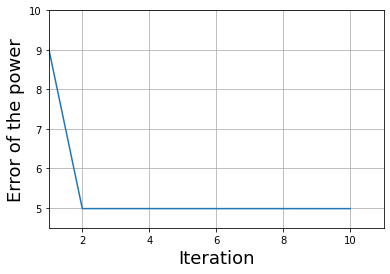

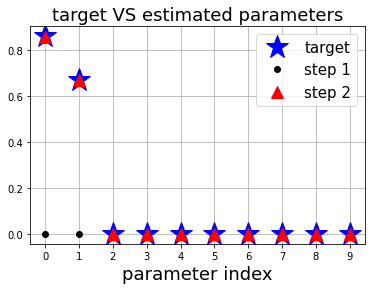

In [12]:
plt.plot(np.arange(1, order+1), PH)
plt.ylim(4.5,10)
plt.xlim(1,order+1)
plt.grid(True)
# plt.title("误差功率随迭代次数变化")
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Error of the power", fontsize=18)
plt.savefig("output/error_of_iter.pdf", bbox_inches='tight',)
plt.figure()
aa = np.pad(a0[1:], (0,len(A)-len(a0)+1))
plt.plot(np.arange(len(A)), aa, "*b", markersize=24,label="target")
plt.plot(np.arange(len(A)), AH[0], ".k", markersize=12,label="step 1")
plt.plot(np.arange(len(A)), AH[1], "^r", markersize=12,label="step 2")
# plt.plot(np.arange(len(A)), AH[9], ".y", markersize=12,label="step 9")
# plt.plot(np.arange(len(A)), A, "^r", markersize=12,label="estimated")
plt.xticks(np.arange(len(A)))
plt.xlabel("parameter index", fontsize=18)
plt.grid(True)
plt.title("target VS estimated parameters", fontsize=18)
plt.legend(fontsize=15)
plt.savefig("output/parameters.pdf", bbox_inches='tight',)
plt.show()

[ 1  2  3  4  5  6  7  8  9 10]


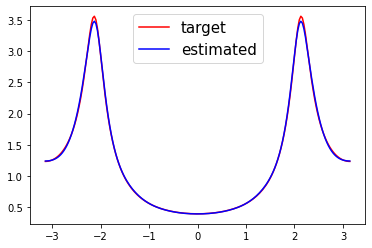

In [13]:
# 计算AR功率谱
var = 1.
w = np.linspace(-np.pi,np.pi,200)
t = np.array([1,2])
ww = w[:,None]*t
S = var/np.abs(1+np.dot(np.exp(-1j*ww),a0[1:]))
plt.plot(w,S,"r",label="target")

t2 = np.arange(1,11)
print(t2)
ww2 = w[:,None]*t2
Se = var/np.abs(1+np.dot(np.exp(-1j*ww2),A))

plt.plot(w,Se,"b",label="estimated")
plt.legend(fontsize=15)
plt.savefig("output/power_est.pdf")
